In [252]:
%matplotlib inline
#---Import libraries
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
import gensim
import logging
from gensim import corpora
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from readability_score.calculators.fleschkincaid import *
from readability_score.calculators.dalechall import *
import datetime as dt
import unicodedata
import seaborn as sns
sns.set(style="darkgrid")
from ggplot import *
import warnings
warnings.filterwarnings('ignore')


In [127]:
#---Set up stopwords and functions
stop = stopwords.words('english')
def sanitize():
    return cleaned_text

def strip_accents(s):
    "Remove those little naughty, pain-giving characters!"
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn') 

In [224]:
#---Read data
file_ = "fake.csv"
df = pd.read_csv(file_)

In [207]:
#---View data and check data types
df.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,25689.0,BREAKING: Weiner Cooperating With FBI On Hilla...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,25689.0,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,25689.0,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias


In [208]:
df.dtypes

uuid                   object
ord_in_thread           int64
author                 object
published              object
title                  object
text                   object
language               object
crawled                object
site_url               object
country                object
domain_rank           float64
thread_title           object
spam_score            float64
main_img_url           object
replies_count           int64
participants_count      int64
likes                   int64
comments                int64
shares                  int64
type                   object
dtype: object

### Data Processing

In [226]:
df['published']  = pd.to_datetime(df['published']).apply(lambda x: x.date())

In [227]:
df['published'].head()

0    2016-10-26
1    2016-10-29
2    2016-10-30
3    2016-11-01
4    2016-11-01
Name: published, dtype: object

In [211]:
df['published'][0]

datetime.date(2016, 10, 26)

In [212]:
#--- Filter data by a spam score of 30%, We change this later
#dfFake = df[df['spam_score'] >= 0.30]

In [225]:
#--- Initial Text cleaning
df['title'] = df['title'].str.lower() #lower case
df['title'] = df['title'].str.replace('[^\w\s]','') #remove punctuation and
df['title'] = df['title'].str.replace('\d+', '') #...numbers

df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('[^\w\s]','') #remove punctuation and
df['text'] = df['text'].str.replace('\d+', '') #...numbers
df['text'] = df['text'].astype(str)
df['text'] = [x.replace("\r\n","") for x in df['text']]
df['text'] = [x.replace("\n","") for x in df['text']]
df['text'] = [x.replace("2x","") for x in df['text']]

### Initial Exploration

In [228]:
#--- Plot publications over the years
publicationsPerDate = df.groupby('published')['title'].count().reset_index()

In [229]:
max(publicationsPerDate['published'])

datetime.date(2016, 11, 25)

In [230]:
min(publicationsPerDate['published'])

datetime.date(2016, 10, 25)

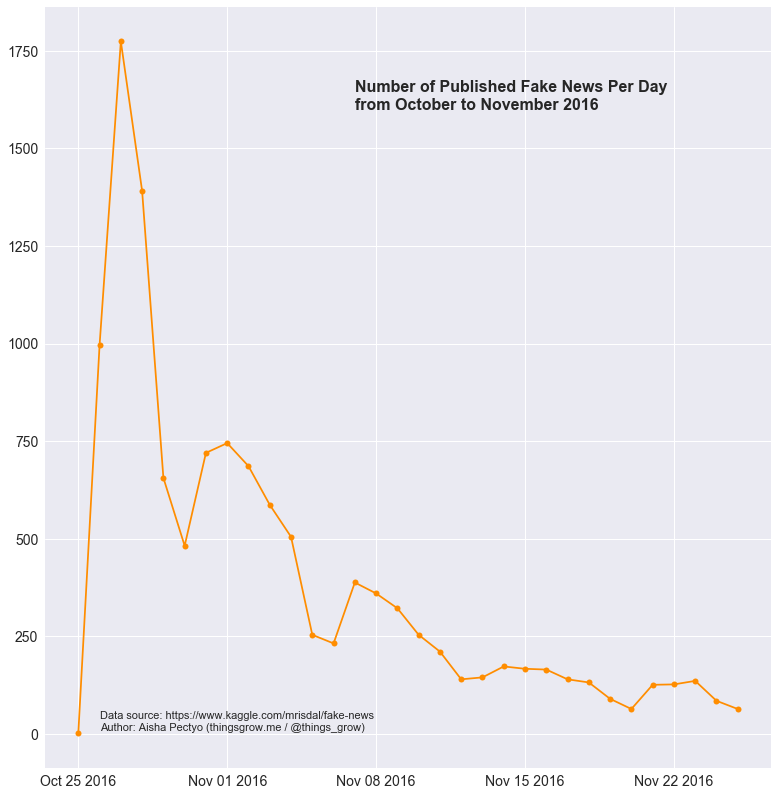

In [231]:
#fontweight="bold"
plt.figure(figsize=(13, 14))    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 
dateFmt = mdates.DateFormatter('%b %d %Y')
ax.xaxis_date()
ax.xaxis.set_major_formatter(dateFmt)
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
plt.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)   
plt.plot(publicationsPerDate['published'], publicationsPerDate['title'], color='#ff8d00', marker = '.', markersize=12)
plt.text(dt.date(2016, 11, 7), 1600, "Number of Published Fake News Per Day"+"\n"+"from October to November 2016", fontsize=16, fontweight="bold")
plt.text(dt.date(2016, 10, 26), 10, "Data source: https://www.kaggle.com/mrisdal/fake-news"    
       "\nAuthor: Aisha Pectyo (thingsgrow.me / @things_grow)", fontsize=11) 
plt.savefig("1.png", bbox_inches="tight");  


In [232]:
#---Publications by source, where are the top fake news coming from?
publicationsPerSource = df.groupby(['author', 'site_url'])['title'].count().reset_index()
publicationsPerSource.sort_values('title', axis=0, ascending=True, inplace=True)
(publicationsPerSource).tail(10)

,author,site_url,title
519,Dave Hodges,thecommonsenseshow.com,99
241,BareNakedIslam,barenakedislam.com,99
636,Editor,theeventchronicle.com,99
2344,noreply@blogger.com (Alexander Light),humansarefree.com,99
634,Eddy Lavine,worldtruth.tv,100
1523,Pakalert,pakalertpress.com,100
772,Gillian,shiftfrequency.com,100
71,Alex Ansary,amtvmedia.com,100
2155,admin,jewsnews.co.il,100
1865,Starkman,topinfopost.com,100


In [233]:
publicationsPerSource['title'].sum()

9895L

In [234]:
#---Publications by country, where are the top fake news coming from?
publicationsPerCountry = df.groupby('country')['title'].count().reset_index()
publicationsPerCountry.sort_values('title', axis=0, ascending=True, inplace=True)
(publicationsPerCountry).tail(10)

,country,title
7,ES,100
14,IS,100
2,CA,103
8,EU,112
5,DE,191
21,TV,201
9,FR,207
18,RU,400
10,GB,831
22,US,9720


In [235]:
#---Likes per author
likesPerAuthor = df.groupby('author')['likes'].count().reset_index()
likesPerAuthor.sort_values('likes', axis=0, ascending=True, inplace=True)
(likesPerAuthor).tail(10)

,author,likes
230,BareNakedIslam,99
484,Dave Hodges,99
2122,noreply@blogger.com (Alexander Light),99
1381,Pakalert,100
710,Gillian,100
1677,Starkman,100
67,Alex Ansary,100
587,Editor,100
586,Eddy Lavine,100
1942,admin,247


In [236]:
#---Likes per publication
likesPerSource = df.groupby('site_url')['likes'].count().reset_index()
likesPerSource.sort_values('likes', axis=0, ascending=True, inplace=True)
(likesPerSource).tail(10)

,site_url,likes
71,fromthetrenchesworldreport.com,100
157,russia-insider.com,100
72,frontpagemag.com,100
73,galacticconnection.com,100
154,rt.com,100
152,rinf.com,100
151,returnofkings.com,100
76,godlikeproductions.com,100
164,silverdoctors.com,100
243,zerohedge.com,100


### Modeling 

In [186]:
#---Explore titles- What do the titles say?
df['title'] = df['title'].astype(str)
docs = df['title'].tolist()
#Remove stopwords
for j in xrange(len(docs)):
    docs[j] = " ".join([i for i in docs[j].lower().split() if i not in stop])
    
#---Set up LDA
#You need the next two lines to be able to use the gensim package
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO
 
#tokenize your sentences
from nltk.tokenize import word_tokenize
tokenized_sents = [word_tokenize(i) for i in docs]
 
#define the dictionary you will use to train the model
id2word = corpora.Dictionary(tokenized_sents)
 
#turn it into a dtm
corpus = [id2word.doc2bow(doc) for doc in tokenized_sents]
 
#Run the model and print
lda_model = gensim.models.ldamodel.LdaModel
result_lda_model = lda_model(corpus, num_topics=6, id2word = corpora.Dictionary(tokenized_sents), passes=50)
 
#the output from this is kind of messy, so we'll use pprint
from pprint import pprint
pprint(result_lda_model.print_topics(num_topics=6, num_words=5))


INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(15217 unique tokens: [u'writings', u'bouddhisme', u'sowell', u'foul', u'four']...)
INFO : built Dictionary(17572 unique tokens: [u'writings', u'bouddhisme', u'sowell', u'foul', u'four']...) from 12999 documents (total 95834 corpus positions)
INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(15217 unique tokens: [u'writings', u'bouddhisme', u'sowell', u'foul', u'four']...)
INFO : built Dictionary(17572 unique tokens: [u'writings', u'bouddhisme', u'sowell', u'foul', u'four']...) from 12999 documents (total 95834 corpus positions)
INFO : using symmetric alpha at 0.166666666667
INFO : using symmetric eta at 0.166666666667
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 6 topics, 50 passes over the supplied corpus of 12999 documents, updating model once every 2000 documents, evaluating pe

INFO : topic #1 (0.167): 0.029*"clinton" + 0.021*"hillary" + 0.020*"trump" + 0.010*"fbi" + 0.008*"russia" + 0.008*"us" + 0.007*"wikileaks" + 0.007*"war" + 0.006*"syria" + 0.006*"campaign"
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.005*"russian" + 0.005*"russia" + 0.005*"new" + 0.005*"syrian" + 0.005*"aleppo" + 0.004*"us" + 0.004*"man" + 0.004*"clinton"
INFO : topic #2 (0.167): 0.009*"la" + 0.008*"trump" + 0.006*"scientists" + 0.005*"rock" + 0.005*"standing" + 0.005*"en" + 0.004*"know" + 0.004*"por" + 0.004*"vladimir" + 0.004*"donald"
INFO : topic diff=0.375624, rho=0.377964
INFO : PROGRESS: pass 1, at document #2000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.028*"clinton" + 0.022*"trump" + 0.020*"hillary" + 0.008*"us" + 0.008*"fbi" + 0.008*"war" + 0.007*"wikileaks" + 0.007*"russia" + 0.006*"syria" + 0.006*"breaking"
INFO : topic #4 (0.167): 0.012*"hillary" + 0.011*"clinton" + 0.006*"emails" + 0.006*"trump" 

INFO : topic diff=0.250853, rho=0.353553
INFO : PROGRESS: pass 2, at document #2000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.015*"trump" + 0.008*"news" + 0.005*"syrian" + 0.005*"aleppo" + 0.005*"new" + 0.005*"russian" + 0.004*"us" + 0.004*"muslim" + 0.004*"russia" + 0.004*"video"
INFO : topic #1 (0.167): 0.031*"clinton" + 0.024*"trump" + 0.023*"hillary" + 0.010*"fbi" + 0.008*"us" + 0.008*"wikileaks" + 0.008*"war" + 0.007*"russia" + 0.007*"syria" + 0.006*"campaign"
INFO : topic #2 (0.167): 0.008*"trump" + 0.007*"la" + 0.005*"scientists" + 0.005*"rock" + 0.004*"know" + 0.004*"standing" + 0.004*"en" + 0.003*"donald" + 0.003*"un" + 0.003*"por"
INFO : topic #0 (0.167): 0.080*"nan" + 0.017*"election" + 0.011*"hillary" + 0.010*"trump" + 0.008*"us" + 0.006*"trumps" + 0.005*"clinton" + 0.005*"video" + 0.005*"american" + 0.004*"day"
INFO : topic #4 (0.167): 0.012*"hillary" + 0.010*"clinton" + 0.007*"emails" + 0.006*"fbi" + 0.005*

INFO : topic #4 (0.167): 0.011*"hillary" + 0.010*"clinton" + 0.006*"emails" + 0.006*"fbi" + 0.005*"2016" + 0.005*"comment" + 0.005*"trump" + 0.005*"media" + 0.005*"email" + 0.004*"new"
INFO : topic #1 (0.167): 0.033*"clinton" + 0.026*"trump" + 0.025*"hillary" + 0.010*"fbi" + 0.008*"us" + 0.008*"wikileaks" + 0.007*"war" + 0.007*"russia" + 0.007*"campaign" + 0.007*"syria"
INFO : topic diff=0.205361, rho=0.316228
INFO : PROGRESS: pass 3, at document #4000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #4 (0.167): 0.014*"hillary" + 0.011*"clinton" + 0.008*"comment" + 0.007*"emails" + 0.007*"fbi" + 0.006*"2016" + 0.005*"clintons" + 0.005*"new" + 0.005*"media" + 0.005*"trump"
INFO : topic #5 (0.167): 0.013*"de" + 0.012*"us" + 0.010*"trump" + 0.007*"world" + 0.007*"election" + 0.006*"new" + 0.005*"war" + 0.005*"news" + 0.005*"americas" + 0.005*"dr"
INFO : topic #3 (0.167): 0.015*"trump" + 0.009*"news" + 0.005*"obama" + 0.005*"new" + 0.005*"russia

INFO : topic #5 (0.167): 0.013*"de" + 0.012*"us" + 0.009*"trump" + 0.007*"world" + 0.006*"election" + 0.006*"war" + 0.006*"new" + 0.006*"news" + 0.005*"americas" + 0.005*"police"
INFO : topic #2 (0.167): 0.010*"la" + 0.007*"un" + 0.007*"trump" + 0.006*"el" + 0.005*"en" + 0.004*"november" + 0.004*"daily" + 0.004*"comment" + 0.003*"know" + 0.003*"rock"
INFO : topic #0 (0.167): 0.058*"nan" + 0.017*"election" + 0.012*"hillary" + 0.011*"trump" + 0.008*"us" + 0.006*"day" + 0.006*"trumps" + 0.006*"video" + 0.005*"comment" + 0.005*"clinton"
INFO : topic #3 (0.167): 0.015*"trump" + 0.009*"news" + 0.005*"obama" + 0.005*"new" + 0.005*"syrian" + 0.005*"russian" + 0.004*"video" + 0.004*"us" + 0.004*"aleppo" + 0.004*"back"
INFO : topic diff=0.206830, rho=0.301511
INFO : PROGRESS: pass 4, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.035*"clinton" + 0.030*"hillary" + 0.028*"trump" + 0.013*"fbi" + 0.009*"wikileaks" + 0.008

INFO : topic #4 (0.167): 0.013*"hillary" + 0.010*"clinton" + 0.008*"comment" + 0.006*"emails" + 0.006*"fbi" + 0.006*"2016" + 0.005*"clintons" + 0.005*"media" + 0.005*"new" + 0.005*"trump"
INFO : topic diff=0.187838, rho=0.288675
INFO : PROGRESS: pass 5, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.016*"trump" + 0.008*"news" + 0.007*"new" + 0.006*"obama" + 0.006*"gold" + 0.005*"video" + 0.004*"us" + 0.004*"syrian" + 0.004*"back" + 0.004*"russian"
INFO : topic #1 (0.167): 0.035*"clinton" + 0.031*"hillary" + 0.029*"trump" + 0.013*"fbi" + 0.009*"wikileaks" + 0.008*"campaign" + 0.008*"us" + 0.007*"donald" + 0.007*"video" + 0.006*"emails"
INFO : topic #0 (0.167): 0.043*"nan" + 0.018*"election" + 0.013*"trump" + 0.012*"hillary" + 0.009*"us" + 0.007*"information" + 0.007*"video" + 0.007*"trumps" + 0.006*"day" + 0.005*"new"
INFO : topic #2 (0.167): 0.010*"la" + 0.009*"le" + 0.007*"gorafi" + 0.007*"trump" + 0.006*"u

INFO : topic #5 (0.167): 0.012*"us" + 0.009*"trump" + 0.007*"world" + 0.007*"election" + 0.006*"war" + 0.006*"new" + 0.005*"3" + 0.005*"news" + 0.005*"police" + 0.005*"americas"
INFO : topic #4 (0.167): 0.014*"hillary" + 0.010*"clinton" + 0.007*"fbi" + 0.006*"comment" + 0.006*"emails" + 0.005*"media" + 0.005*"2016" + 0.005*"email" + 0.005*"trump" + 0.005*"new"
INFO : topic #2 (0.167): 0.011*"de" + 0.010*"la" + 0.009*"le" + 0.007*"gorafi" + 0.006*"trump" + 0.006*"un" + 0.005*"en" + 0.005*"el" + 0.004*"para" + 0.004*"november"
INFO : topic diff=0.153250, rho=0.277350
INFO : PROGRESS: pass 6, at document #8000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #4 (0.167): 0.014*"hillary" + 0.010*"clinton" + 0.007*"fbi" + 0.006*"emails" + 0.006*"comey" + 0.005*"media" + 0.005*"big" + 0.005*"comment" + 0.005*"email" + 0.005*"2016"
INFO : topic #5 (0.167): 0.011*"us" + 0.011*"world" + 0.011*"3" + 0.010*"war" + 0.008*"trump" + 0.006*"election" + 0.00

INFO : PROGRESS: pass 7, at document #8000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.033*"clinton" + 0.031*"trump" + 0.030*"hillary" + 0.013*"fbi" + 0.008*"campaign" + 0.008*"donald" + 0.008*"wikileaks" + 0.007*"us" + 0.007*"russia" + 0.006*"new"
INFO : topic #5 (0.167): 0.011*"us" + 0.011*"world" + 0.010*"war" + 0.010*"3" + 0.008*"trump" + 0.006*"election" + 0.006*"new" + 0.005*"police" + 0.005*"news" + 0.005*"russia"
INFO : topic #2 (0.167): 0.013*"de" + 0.009*"la" + 0.008*"le" + 0.006*"trump" + 0.006*"un" + 0.005*"gorafi" + 0.004*"en" + 0.004*"november" + 0.004*"el" + 0.003*"daily"
INFO : topic #3 (0.167): 0.016*"trump" + 0.009*"news" + 0.007*"new" + 0.005*"obama" + 0.005*"us" + 0.005*"russian" + 0.005*"gold" + 0.004*"video" + 0.004*"back" + 0.004*"syrian"
INFO : topic #0 (0.167): 0.035*"nan" + 0.018*"election" + 0.014*"trump" + 0.011*"hillary" + 0.009*"us" + 0.006*"trumps" + 0.006*"day" + 0.006*"video" + 0.005*"infor

INFO : topic #0 (0.167): 0.036*"nan" + 0.018*"election" + 0.014*"trump" + 0.011*"hillary" + 0.009*"us" + 0.006*"trumps" + 0.006*"day" + 0.006*"video" + 0.005*"information" + 0.005*"new"
INFO : topic #1 (0.167): 0.033*"clinton" + 0.031*"trump" + 0.031*"hillary" + 0.013*"fbi" + 0.008*"donald" + 0.008*"campaign" + 0.008*"wikileaks" + 0.007*"us" + 0.007*"russia" + 0.006*"new"
INFO : topic diff=0.127629, rho=0.258199
INFO : PROGRESS: pass 8, at document #10000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #4 (0.167): 0.012*"hillary" + 0.010*"clinton" + 0.006*"emails" + 0.006*"fbi" + 0.006*"comment" + 0.005*"big" + 0.005*"email" + 0.005*"media" + 0.005*"2016" + 0.005*"new"
INFO : topic #3 (0.167): 0.015*"trump" + 0.008*"news" + 0.006*"gold" + 0.006*"new" + 0.005*"us" + 0.005*"russian" + 0.004*"video" + 0.004*"aleppo" + 0.004*"obama" + 0.004*"fake"
INFO : topic #2 (0.167): 0.016*"de" + 0.010*"la" + 0.006*"en" + 0.006*"un" + 0.006*"le" + 0.005*"t

INFO : topic #4 (0.167): 0.012*"hillary" + 0.009*"clinton" + 0.006*"emails" + 0.006*"fbi" + 0.006*"comment" + 0.005*"big" + 0.005*"media" + 0.005*"2016" + 0.005*"email" + 0.005*"comey"
INFO : topic #3 (0.167): 0.015*"trump" + 0.008*"news" + 0.006*"gold" + 0.006*"new" + 0.005*"us" + 0.005*"russian" + 0.004*"video" + 0.004*"aleppo" + 0.004*"obama" + 0.004*"fake"
INFO : topic #2 (0.167): 0.016*"de" + 0.010*"la" + 0.006*"en" + 0.006*"un" + 0.006*"le" + 0.005*"trump" + 0.005*"el" + 0.005*"november" + 0.004*"gorafi" + 0.003*"save"
INFO : topic #1 (0.167): 0.033*"clinton" + 0.029*"hillary" + 0.029*"trump" + 0.012*"fbi" + 0.008*"campaign" + 0.008*"us" + 0.008*"russia" + 0.007*"donald" + 0.007*"wikileaks" + 0.006*"new"
INFO : topic #5 (0.167): 0.012*"us" + 0.009*"world" + 0.009*"war" + 0.008*"3" + 0.008*"trump" + 0.007*"election" + 0.007*"police" + 0.006*"russia" + 0.006*"new" + 0.005*"americas"
INFO : topic diff=0.119398, rho=0.250000
INFO : PROGRESS: pass 9, at document #12000/12999
INFO : me

INFO : topic #1 (0.167): 0.033*"clinton" + 0.030*"hillary" + 0.029*"trump" + 0.012*"fbi" + 0.008*"campaign" + 0.008*"us" + 0.008*"donald" + 0.007*"wikileaks" + 0.007*"russia" + 0.006*"new"
INFO : topic diff=0.114434, rho=0.242536
INFO : PROGRESS: pass 10, at document #12000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.011*"americas" + 0.011*"us" + 0.011*"news" + 0.009*"source" + 0.009*"war" + 0.009*"world" + 0.008*"onion" + 0.008*"finest" + 0.008*"election" + 0.008*"trump"
INFO : topic #1 (0.167): 0.033*"clinton" + 0.030*"trump" + 0.030*"hillary" + 0.013*"fbi" + 0.008*"campaign" + 0.008*"russia" + 0.008*"donald" + 0.007*"us" + 0.007*"wikileaks" + 0.007*"breaking"
INFO : topic #0 (0.167): 0.030*"nan" + 0.019*"election" + 0.013*"trump" + 0.010*"hillary" + 0.009*"us" + 0.007*"trumps" + 0.006*"veterans" + 0.005*"video" + 0.005*"paul" + 0.005*"american"
INFO : topic #2 (0.167): 0.014*"de" + 0.010*"la" + 0.005*"en" + 0.005*"trump

INFO : topic #2 (0.167): 0.014*"de" + 0.010*"la" + 0.005*"en" + 0.005*"november" + 0.005*"trump" + 0.005*"un" + 0.005*"le" + 0.004*"el" + 0.003*"save" + 0.003*"know"
INFO : topic #5 (0.167): 0.011*"americas" + 0.011*"us" + 0.010*"news" + 0.009*"source" + 0.009*"war" + 0.009*"world" + 0.008*"onion" + 0.008*"finest" + 0.008*"election" + 0.008*"trump"
INFO : topic #3 (0.167): 0.014*"trump" + 0.011*"news" + 0.006*"russian" + 0.006*"us" + 0.005*"new" + 0.005*"syrian" + 0.005*"russia" + 0.005*"aleppo" + 0.005*"gold" + 0.004*"video"
INFO : topic #1 (0.167): 0.033*"clinton" + 0.030*"trump" + 0.030*"hillary" + 0.013*"fbi" + 0.008*"campaign" + 0.008*"donald" + 0.008*"russia" + 0.007*"us" + 0.007*"wikileaks" + 0.007*"breaking"
INFO : topic diff=0.112985, rho=0.235702
INFO : -9.180 per-word bound, 580.1 perplexity estimate based on a held-out corpus of 999 documents with 6176 words
INFO : PROGRESS: pass 11, at document #12999/12999
INFO : merging changes from 999 documents into a model of 12999 do

INFO : topic #1 (0.167): 0.033*"clinton" + 0.030*"trump" + 0.030*"hillary" + 0.013*"fbi" + 0.008*"donald" + 0.008*"campaign" + 0.008*"russia" + 0.007*"us" + 0.007*"wikileaks" + 0.007*"breaking"
INFO : topic diff=0.109001, rho=0.229416
INFO : -9.171 per-word bound, 576.4 perplexity estimate based on a held-out corpus of 999 documents with 6176 words
INFO : PROGRESS: pass 12, at document #12999/12999
INFO : merging changes from 999 documents into a model of 12999 documents
INFO : topic #2 (0.167): 0.014*"de" + 0.011*"la" + 0.006*"en" + 0.004*"un" + 0.004*"trump" + 0.004*"el" + 0.004*"le" + 0.004*"scientists" + 0.004*"november" + 0.004*"por"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.030*"hillary" + 0.029*"trump" + 0.013*"fbi" + 0.008*"wikileaks" + 0.008*"donald" + 0.007*"campaign" + 0.007*"us" + 0.007*"russia" + 0.007*"emails"
INFO : topic #0 (0.167): 0.054*"nan" + 0.019*"election" + 0.011*"trump" + 0.009*"hillary" + 0.009*"us" + 0.006*"trumps" + 0.005*"video" + 0.005*"veterans" + 0.00

INFO : topic #4 (0.167): 0.011*"hillary" + 0.010*"clinton" + 0.006*"emails" + 0.005*"2016" + 0.005*"fbi" + 0.005*"comey" + 0.005*"podesta" + 0.005*"media" + 0.004*"big" + 0.004*"hillarys"
INFO : topic #2 (0.167): 0.014*"de" + 0.011*"la" + 0.006*"en" + 0.004*"un" + 0.004*"trump" + 0.004*"el" + 0.004*"le" + 0.004*"scientists" + 0.004*"por" + 0.004*"know"
INFO : topic #3 (0.167): 0.014*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"russian" + 0.005*"syrian" + 0.005*"new" + 0.005*"russia" + 0.004*"aleppo" + 0.004*"back" + 0.004*"gold"
INFO : topic #0 (0.167): 0.054*"nan" + 0.019*"election" + 0.011*"trump" + 0.009*"hillary" + 0.009*"us" + 0.006*"trumps" + 0.005*"video" + 0.005*"veterans" + 0.005*"paul" + 0.004*"day"
INFO : topic diff=0.095964, rho=0.223607
INFO : PROGRESS: pass 14, at document #2000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #2 (0.167): 0.012*"de" + 0.009*"la" + 0.005*"trump" + 0.005*"en" + 0.004*"un" + 0.004*"know" + 0.003*"

INFO : topic #3 (0.167): 0.014*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"russian" + 0.005*"syrian" + 0.005*"new" + 0.005*"russia" + 0.004*"aleppo" + 0.004*"back" + 0.004*"gold"
INFO : topic diff=0.093223, rho=0.218218
INFO : PROGRESS: pass 15, at document #2000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #4 (0.167): 0.010*"hillary" + 0.009*"clinton" + 0.006*"emails" + 0.005*"comment" + 0.005*"2016" + 0.005*"fbi" + 0.005*"media" + 0.004*"podesta" + 0.004*"big" + 0.004*"comey"
INFO : topic #5 (0.167): 0.012*"us" + 0.008*"war" + 0.008*"world" + 0.008*"americas" + 0.008*"news" + 0.007*"trump" + 0.006*"election" + 0.006*"police" + 0.006*"3" + 0.006*"source"
INFO : topic #1 (0.167): 0.035*"clinton" + 0.030*"trump" + 0.030*"hillary" + 0.012*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"campaign" + 0.007*"breaking" + 0.007*"russia"
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.005*"us" + 0.005*"syrian" + 0.005*

INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.005*"us" + 0.005*"syrian" + 0.005*"new" + 0.005*"russian" + 0.005*"aleppo" + 0.004*"muslim" + 0.004*"back" + 0.004*"russia"
INFO : topic #2 (0.167): 0.012*"de" + 0.009*"la" + 0.005*"trump" + 0.005*"en" + 0.004*"un" + 0.004*"know" + 0.004*"le" + 0.003*"el" + 0.003*"scientists" + 0.003*"november"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.030*"trump" + 0.030*"hillary" + 0.012*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"campaign" + 0.007*"breaking" + 0.007*"russia"
INFO : topic diff=0.098044, rho=0.208514
INFO : PROGRESS: pass 16, at document #4000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.036*"clinton" + 0.033*"hillary" + 0.030*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"campaign" + 0.006*"investigation" + 0.006*"president"
INFO : topic #0 (0.167): 0.055*"nan" + 0.018*"election" + 0.012*"trump" + 0.009*"hil

INFO : topic diff=0.095541, rho=0.204124
INFO : PROGRESS: pass 17, at document #4000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.012*"us" + 0.008*"world" + 0.007*"war" + 0.007*"news" + 0.007*"trump" + 0.007*"americas" + 0.006*"election" + 0.006*"police" + 0.006*"3" + 0.005*"new"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.008*"comment" + 0.006*"emails" + 0.006*"2016" + 0.005*"fbi" + 0.005*"media" + 0.005*"clintons" + 0.004*"hillarys" + 0.004*"trump"
INFO : topic #0 (0.167): 0.055*"nan" + 0.018*"election" + 0.012*"trump" + 0.009*"hillary" + 0.008*"us" + 0.006*"day" + 0.006*"trumps" + 0.005*"video" + 0.005*"comment" + 0.004*"foreign"
INFO : topic #1 (0.167): 0.037*"clinton" + 0.033*"hillary" + 0.030*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"campaign" + 0.007*"investigation" + 0.006*"new"
INFO : topic #2 (0.167): 0.016*"de" + 0.010*"la" + 0.006*"un" + 0.005*"el" + 0.00

INFO : topic #0 (0.167): 0.055*"nan" + 0.018*"election" + 0.012*"trump" + 0.009*"hillary" + 0.008*"us" + 0.006*"day" + 0.006*"trumps" + 0.005*"video" + 0.005*"comment" + 0.004*"foreign"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.008*"comment" + 0.006*"emails" + 0.006*"2016" + 0.005*"fbi" + 0.005*"media" + 0.005*"clintons" + 0.004*"hillarys" + 0.004*"trump"
INFO : topic #3 (0.167): 0.014*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"new" + 0.005*"russian" + 0.005*"syrian" + 0.005*"obama" + 0.004*"muslim" + 0.004*"aleppo" + 0.004*"video"
INFO : topic diff=0.111484, rho=0.200000
INFO : PROGRESS: pass 18, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.012*"us" + 0.008*"world" + 0.007*"war" + 0.007*"trump" + 0.007*"election" + 0.006*"news" + 0.006*"americas" + 0.006*"police" + 0.006*"3" + 0.006*"new"
INFO : topic #3 (0.167): 0.015*"trump" + 0.009*"news" + 0.007*"new" + 0.005*"obama" + 0.005*"go

INFO : topic diff=0.108775, rho=0.196116
INFO : PROGRESS: pass 19, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.038*"clinton" + 0.033*"hillary" + 0.032*"trump" + 0.014*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.008*"campaign" + 0.008*"us" + 0.007*"investigation" + 0.007*"video"
INFO : topic #4 (0.167): 0.012*"hillary" + 0.009*"clinton" + 0.006*"comment" + 0.006*"emails" + 0.005*"2016" + 0.005*"fbi" + 0.005*"media" + 0.004*"big" + 0.004*"comey" + 0.004*"trump"
INFO : topic #3 (0.167): 0.015*"trump" + 0.009*"news" + 0.007*"new" + 0.005*"obama" + 0.005*"gold" + 0.005*"us" + 0.005*"video" + 0.004*"syrian" + 0.004*"muslim" + 0.004*"russian"
INFO : topic #0 (0.167): 0.046*"nan" + 0.018*"election" + 0.012*"trump" + 0.009*"hillary" + 0.009*"us" + 0.006*"trumps" + 0.006*"video" + 0.006*"information" + 0.006*"day" + 0.005*"new"
INFO : topic #5 (0.167): 0.012*"us" + 0.008*"world" + 0.007*"war" + 0.007*"trump" + 0

INFO : topic #0 (0.167): 0.046*"nan" + 0.018*"election" + 0.012*"trump" + 0.009*"us" + 0.009*"hillary" + 0.006*"trumps" + 0.006*"video" + 0.006*"information" + 0.006*"day" + 0.005*"new"
INFO : topic #2 (0.167): 0.015*"de" + 0.010*"la" + 0.008*"le" + 0.006*"un" + 0.006*"gorafi" + 0.006*"trump" + 0.005*"en" + 0.005*"el" + 0.004*"november" + 0.003*"para"
INFO : topic #5 (0.167): 0.012*"us" + 0.008*"world" + 0.007*"war" + 0.007*"trump" + 0.007*"election" + 0.006*"news" + 0.006*"americas" + 0.006*"police" + 0.006*"3" + 0.006*"new"
INFO : topic diff=0.092697, rho=0.192450
INFO : PROGRESS: pass 20, at document #8000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.015*"trump" + 0.010*"news" + 0.006*"new" + 0.005*"us" + 0.005*"russian" + 0.005*"obama" + 0.005*"gold" + 0.004*"video" + 0.004*"syrian" + 0.004*"back"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.033*"hillary" + 0.032*"trump" + 0.013*"fbi" + 0.010*"donald" + 0.008*"campaign"

INFO : topic diff=0.090646, rho=0.188982
INFO : PROGRESS: pass 21, at document #8000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #4 (0.167): 0.012*"hillary" + 0.009*"clinton" + 0.006*"emails" + 0.005*"comment" + 0.005*"fbi" + 0.005*"comey" + 0.005*"media" + 0.005*"2016" + 0.005*"big" + 0.004*"trump"
INFO : topic #0 (0.167): 0.039*"nan" + 0.018*"election" + 0.013*"trump" + 0.009*"us" + 0.008*"hillary" + 0.006*"trumps" + 0.006*"day" + 0.005*"video" + 0.005*"information" + 0.005*"new"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.033*"hillary" + 0.032*"trump" + 0.013*"fbi" + 0.010*"donald" + 0.008*"campaign" + 0.008*"wikileaks" + 0.007*"us" + 0.007*"investigation" + 0.007*"new"
INFO : topic #5 (0.167): 0.012*"us" + 0.011*"world" + 0.010*"war" + 0.009*"3" + 0.006*"trump" + 0.006*"election" + 0.006*"news" + 0.006*"police" + 0.006*"new" + 0.005*"russia"
INFO : topic #3 (0.167): 0.015*"trump" + 0.010*"news" + 0.006*"new" + 0.005*"us" + 0.005*"r

INFO : topic #0 (0.167): 0.040*"nan" + 0.019*"election" + 0.013*"trump" + 0.009*"us" + 0.008*"hillary" + 0.006*"trumps" + 0.006*"day" + 0.005*"video" + 0.005*"information" + 0.005*"new"
INFO : topic #2 (0.167): 0.015*"de" + 0.009*"la" + 0.007*"le" + 0.006*"un" + 0.005*"trump" + 0.005*"gorafi" + 0.005*"en" + 0.004*"el" + 0.004*"november" + 0.003*"daily"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.033*"hillary" + 0.032*"trump" + 0.013*"fbi" + 0.010*"donald" + 0.008*"campaign" + 0.008*"wikileaks" + 0.007*"us" + 0.007*"investigation" + 0.007*"new"
INFO : topic diff=0.082807, rho=0.185695
INFO : PROGRESS: pass 22, at document #10000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.006*"comment" + 0.006*"emails" + 0.005*"2016" + 0.005*"media" + 0.005*"big" + 0.005*"comey" + 0.005*"fbi" + 0.005*"podesta"
INFO : topic #5 (0.167): 0.012*"us" + 0.010*"world" + 0.009*"war" + 0.008*"3" + 0.007*"election

INFO : topic diff=0.081105, rho=0.182574
INFO : PROGRESS: pass 23, at document #10000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.006*"gold" + 0.006*"us" + 0.006*"new" + 0.005*"russian" + 0.004*"aleppo" + 0.004*"video" + 0.004*"obama" + 0.004*"fake"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.006*"comment" + 0.006*"emails" + 0.005*"2016" + 0.005*"media" + 0.005*"big" + 0.005*"comey" + 0.005*"fbi" + 0.005*"podesta"
INFO : topic #0 (0.167): 0.032*"nan" + 0.019*"election" + 0.012*"trump" + 0.009*"us" + 0.009*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"day" + 0.005*"foreign" + 0.004*"new"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"campaign" + 0.008*"us" + 0.007*"wikileaks" + 0.007*"investigation" + 0.007*"russia"
INFO : topic #2 (0.167): 0.016*"de" + 0.010*"la" + 0.006*"un" + 0.006*"en" + 0.006*"le"

INFO : topic #5 (0.167): 0.012*"us" + 0.010*"world" + 0.009*"war" + 0.008*"3" + 0.007*"election" + 0.007*"police" + 0.006*"trump" + 0.006*"russia" + 0.006*"americas" + 0.006*"news"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"campaign" + 0.008*"us" + 0.007*"wikileaks" + 0.007*"investigation" + 0.007*"russia"
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.006*"gold" + 0.006*"new" + 0.006*"us" + 0.005*"russian" + 0.004*"aleppo" + 0.004*"video" + 0.004*"obama" + 0.004*"fake"
INFO : topic diff=0.078163, rho=0.179605
INFO : PROGRESS: pass 24, at document #12000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #0 (0.167): 0.034*"nan" + 0.019*"election" + 0.012*"trump" + 0.009*"us" + 0.008*"hillary" + 0.006*"trumps" + 0.005*"veterans" + 0.005*"video" + 0.005*"paul" + 0.005*"day"
INFO : topic #2 (0.167): 0.014*"de" + 0.010*"la" + 0.005*"en" + 0.005*"un" + 0.005*"trump" 

INFO : topic diff=0.076708, rho=0.176777
INFO : PROGRESS: pass 25, at document #12000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.011*"us" + 0.010*"americas" + 0.010*"news" + 0.009*"world" + 0.009*"war" + 0.008*"source" + 0.007*"election" + 0.007*"onion" + 0.007*"finest" + 0.007*"3"
INFO : topic #1 (0.167): 0.035*"clinton" + 0.032*"hillary" + 0.032*"trump" + 0.014*"fbi" + 0.010*"donald" + 0.008*"campaign" + 0.007*"russia" + 0.007*"us" + 0.007*"wikileaks" + 0.007*"investigation"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.006*"2016" + 0.005*"emails" + 0.005*"comment" + 0.005*"comey" + 0.005*"big" + 0.005*"media" + 0.004*"fbi" + 0.004*"podesta"
INFO : topic #2 (0.167): 0.014*"de" + 0.010*"la" + 0.005*"en" + 0.005*"un" + 0.005*"trump" + 0.005*"le" + 0.005*"november" + 0.004*"el" + 0.003*"gorafi" + 0.003*"know"
INFO : topic #0 (0.167): 0.034*"nan" + 0.019*"election" + 0.012*"trump" + 0.009*"us" + 0.008*"hill

INFO : topic #2 (0.167): 0.014*"de" + 0.010*"la" + 0.005*"en" + 0.005*"un" + 0.005*"trump" + 0.005*"le" + 0.005*"november" + 0.004*"el" + 0.003*"gorafi" + 0.003*"know"
INFO : topic #5 (0.167): 0.011*"us" + 0.010*"americas" + 0.010*"news" + 0.009*"world" + 0.009*"war" + 0.008*"source" + 0.007*"election" + 0.007*"onion" + 0.007*"finest" + 0.007*"3"
INFO : topic #3 (0.167): 0.014*"trump" + 0.011*"news" + 0.006*"us" + 0.006*"russian" + 0.005*"new" + 0.005*"syrian" + 0.005*"russia" + 0.005*"aleppo" + 0.005*"gold" + 0.004*"video"
INFO : topic diff=0.077965, rho=0.174078
INFO : -9.097 per-word bound, 547.6 perplexity estimate based on a held-out corpus of 999 documents with 6176 words
INFO : PROGRESS: pass 26, at document #12999/12999
INFO : merging changes from 999 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.038*"clinton" + 0.032*"hillary" + 0.030*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.007*"campaign" + 0.007*"us" + 0.007*"investigation" + 0.00

INFO : topic diff=0.076623, rho=0.171499
INFO : -9.094 per-word bound, 546.4 perplexity estimate based on a held-out corpus of 999 documents with 6176 words
INFO : PROGRESS: pass 27, at document #12999/12999
INFO : merging changes from 999 documents into a model of 12999 documents
INFO : topic #0 (0.167): 0.051*"nan" + 0.020*"election" + 0.011*"trump" + 0.009*"us" + 0.007*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"veterans" + 0.005*"day" + 0.005*"paul"
INFO : topic #3 (0.167): 0.013*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"russian" + 0.005*"new" + 0.005*"syrian" + 0.004*"russia" + 0.004*"aleppo" + 0.004*"gold" + 0.004*"back"
INFO : topic #5 (0.167): 0.011*"us" + 0.009*"world" + 0.009*"americas" + 0.009*"news" + 0.008*"war" + 0.007*"election" + 0.007*"3" + 0.007*"source" + 0.007*"police" + 0.006*"onion"
INFO : topic #4 (0.167): 0.010*"hillary" + 0.009*"clinton" + 0.006*"emails" + 0.005*"2016" + 0.005*"comey" + 0.005*"media" + 0.005*"podesta" + 0.004*"comment" + 0.004*"big" 

INFO : topic #0 (0.167): 0.051*"nan" + 0.020*"election" + 0.011*"trump" + 0.009*"us" + 0.007*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"veterans" + 0.005*"day" + 0.005*"paul"
INFO : topic #1 (0.167): 0.038*"clinton" + 0.032*"hillary" + 0.030*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.007*"campaign" + 0.007*"us" + 0.007*"investigation" + 0.007*"emails"
INFO : topic #5 (0.167): 0.011*"us" + 0.009*"world" + 0.009*"americas" + 0.009*"news" + 0.008*"war" + 0.007*"election" + 0.007*"3" + 0.007*"source" + 0.006*"police" + 0.006*"onion"
INFO : topic #4 (0.167): 0.010*"hillary" + 0.009*"clinton" + 0.006*"emails" + 0.005*"2016" + 0.005*"comey" + 0.005*"media" + 0.005*"podesta" + 0.004*"comment" + 0.004*"big" + 0.004*"fbi"
INFO : topic diff=0.069443, rho=0.169031
INFO : PROGRESS: pass 29, at document #2000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #4 (0.167): 0.010*"hillary" + 0.009*"clinton" + 0.006*"emails" + 0.005

INFO : topic #3 (0.167): 0.013*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"russian" + 0.005*"new" + 0.005*"syrian" + 0.005*"russia" + 0.004*"aleppo" + 0.004*"gold" + 0.004*"back"
INFO : topic diff=0.068356, rho=0.166667
INFO : PROGRESS: pass 30, at document #2000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #4 (0.167): 0.010*"hillary" + 0.008*"clinton" + 0.006*"emails" + 0.005*"comment" + 0.005*"2016" + 0.005*"media" + 0.004*"big" + 0.004*"podesta" + 0.004*"comey" + 0.004*"fbi"
INFO : topic #0 (0.167): 0.062*"nan" + 0.019*"election" + 0.011*"trump" + 0.009*"us" + 0.007*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"day" + 0.005*"american" + 0.004*"rigged"
INFO : topic #1 (0.167): 0.037*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.010*"donald" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"campaign" + 0.007*"investigation" + 0.006*"russia"
INFO : topic #5 (0.167): 0.012*"us" + 0.009*"world" + 0.008*"war" + 0.008*"news" +

INFO : topic #0 (0.167): 0.062*"nan" + 0.019*"election" + 0.011*"trump" + 0.009*"us" + 0.007*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"day" + 0.005*"american" + 0.004*"rigged"
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.005*"us" + 0.005*"new" + 0.005*"syrian" + 0.005*"russian" + 0.005*"aleppo" + 0.004*"muslim" + 0.004*"russia" + 0.004*"back"
INFO : topic #1 (0.167): 0.037*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.010*"donald" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"campaign" + 0.007*"investigation" + 0.006*"breaking"
INFO : topic #2 (0.167): 0.013*"de" + 0.009*"la" + 0.005*"trump" + 0.005*"en" + 0.004*"un" + 0.004*"le" + 0.004*"el" + 0.004*"know" + 0.003*"november" + 0.003*"scientists"
INFO : topic diff=0.072581, rho=0.162221
INFO : PROGRESS: pass 31, at document #4000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.012*"us" + 0.009*"world" + 0.007*"war" + 0.007*"news" + 0.007*"ame

INFO : topic #4 (0.167): 0.010*"hillary" + 0.008*"clinton" + 0.006*"emails" + 0.005*"2016" + 0.005*"comment" + 0.005*"media" + 0.004*"big" + 0.004*"podesta" + 0.004*"comey" + 0.004*"fbi"
INFO : topic diff=0.071462, rho=0.160128
INFO : PROGRESS: pass 32, at document #4000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.012*"us" + 0.009*"world" + 0.007*"war" + 0.007*"news" + 0.007*"americas" + 0.007*"election" + 0.007*"trump" + 0.006*"police" + 0.006*"3" + 0.006*"new"
INFO : topic #3 (0.167): 0.014*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"new" + 0.005*"russian" + 0.005*"syrian" + 0.004*"obama" + 0.004*"aleppo" + 0.004*"muslim" + 0.004*"video"
INFO : topic #2 (0.167): 0.016*"de" + 0.010*"la" + 0.006*"un" + 0.005*"en" + 0.005*"trump" + 0.005*"el" + 0.004*"november" + 0.004*"le" + 0.004*"daily" + 0.003*"know"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.007*"comment" + 0.006*"emails" + 0.006*"2016" + 0.005*"me

INFO : topic #0 (0.167): 0.054*"nan" + 0.018*"election" + 0.011*"trump" + 0.008*"us" + 0.008*"hillary" + 0.006*"day" + 0.006*"trumps" + 0.005*"video" + 0.004*"foreign" + 0.004*"american"
INFO : topic #1 (0.167): 0.037*"clinton" + 0.034*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"campaign" + 0.007*"investigation" + 0.006*"new"
INFO : topic #5 (0.167): 0.012*"us" + 0.009*"world" + 0.007*"war" + 0.007*"news" + 0.007*"americas" + 0.007*"election" + 0.007*"trump" + 0.006*"police" + 0.006*"3" + 0.005*"new"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.007*"comment" + 0.006*"emails" + 0.006*"2016" + 0.005*"media" + 0.005*"clintons" + 0.005*"fbi" + 0.004*"comey" + 0.004*"big"
INFO : topic diff=0.084227, rho=0.158114
INFO : PROGRESS: pass 33, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.038*"clinton" + 0.034*"hillary" + 0.032*"trump" + 0.014*"f

INFO : topic #0 (0.167): 0.054*"nan" + 0.018*"election" + 0.011*"trump" + 0.008*"us" + 0.008*"hillary" + 0.006*"day" + 0.006*"trumps" + 0.005*"video" + 0.004*"foreign" + 0.004*"american"
INFO : topic diff=0.083014, rho=0.156174
INFO : PROGRESS: pass 34, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.038*"clinton" + 0.034*"hillary" + 0.032*"trump" + 0.014*"fbi" + 0.010*"donald" + 0.008*"wikileaks" + 0.008*"campaign" + 0.008*"us" + 0.007*"investigation" + 0.007*"video"
INFO : topic #4 (0.167): 0.012*"hillary" + 0.009*"clinton" + 0.006*"comment" + 0.006*"emails" + 0.006*"2016" + 0.005*"media" + 0.005*"fbi" + 0.005*"big" + 0.005*"comey" + 0.004*"trump"
INFO : topic #0 (0.167): 0.047*"nan" + 0.019*"election" + 0.012*"trump" + 0.009*"us" + 0.008*"hillary" + 0.006*"trumps" + 0.006*"video" + 0.006*"day" + 0.005*"information" + 0.004*"new"
INFO : topic #5 (0.167): 0.012*"us" + 0.008*"world" + 0.007*"war" + 0.007*"ele

INFO : topic #2 (0.167): 0.015*"de" + 0.010*"la" + 0.007*"le" + 0.006*"un" + 0.005*"trump" + 0.005*"en" + 0.005*"gorafi" + 0.005*"el" + 0.004*"november" + 0.003*"para"
INFO : topic #5 (0.167): 0.012*"us" + 0.008*"world" + 0.007*"war" + 0.007*"election" + 0.007*"news" + 0.007*"trump" + 0.006*"americas" + 0.006*"3" + 0.006*"police" + 0.006*"new"
INFO : topic #1 (0.167): 0.038*"clinton" + 0.034*"hillary" + 0.032*"trump" + 0.014*"fbi" + 0.010*"donald" + 0.008*"wikileaks" + 0.008*"campaign" + 0.008*"us" + 0.007*"investigation" + 0.007*"video"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.006*"comment" + 0.006*"emails" + 0.005*"2016" + 0.005*"media" + 0.005*"fbi" + 0.005*"big" + 0.005*"comey" + 0.004*"trump"
INFO : topic diff=0.071424, rho=0.154303
INFO : PROGRESS: pass 35, at document #8000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.015*"trump" + 0.009*"news" + 0.006*"new" + 0.005*"us" + 0.005*"russian" + 0.00

INFO : topic #5 (0.167): 0.012*"us" + 0.008*"world" + 0.007*"war" + 0.007*"news" + 0.007*"election" + 0.007*"trump" + 0.006*"americas" + 0.006*"3" + 0.006*"police" + 0.006*"new"
INFO : topic diff=0.070484, rho=0.152499
INFO : PROGRESS: pass 36, at document #8000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.036*"clinton" + 0.033*"hillary" + 0.032*"trump" + 0.014*"fbi" + 0.010*"donald" + 0.008*"campaign" + 0.008*"wikileaks" + 0.007*"us" + 0.007*"investigation" + 0.007*"new"
INFO : topic #5 (0.167): 0.012*"us" + 0.011*"world" + 0.009*"war" + 0.009*"3" + 0.007*"election" + 0.006*"news" + 0.006*"trump" + 0.006*"police" + 0.006*"americas" + 0.006*"russia"
INFO : topic #0 (0.167): 0.041*"nan" + 0.019*"election" + 0.012*"trump" + 0.009*"us" + 0.008*"hillary" + 0.006*"trumps" + 0.006*"day" + 0.005*"video" + 0.005*"information" + 0.004*"new"
INFO : topic #2 (0.167): 0.015*"de" + 0.009*"la" + 0.007*"le" + 0.006*"un" + 0.005*"trump" + 

INFO : topic #1 (0.167): 0.036*"clinton" + 0.033*"hillary" + 0.032*"trump" + 0.014*"fbi" + 0.010*"donald" + 0.008*"campaign" + 0.008*"wikileaks" + 0.007*"us" + 0.007*"investigation" + 0.007*"new"
INFO : topic #2 (0.167): 0.015*"de" + 0.009*"la" + 0.007*"le" + 0.006*"un" + 0.005*"trump" + 0.005*"en" + 0.004*"gorafi" + 0.004*"el" + 0.004*"november" + 0.003*"daily"
INFO : topic #5 (0.167): 0.012*"us" + 0.011*"world" + 0.009*"war" + 0.009*"3" + 0.007*"election" + 0.006*"news" + 0.006*"trump" + 0.006*"police" + 0.006*"americas" + 0.006*"new"
INFO : topic #4 (0.167): 0.012*"hillary" + 0.009*"clinton" + 0.006*"emails" + 0.006*"comment" + 0.005*"2016" + 0.005*"comey" + 0.005*"media" + 0.005*"fbi" + 0.005*"big" + 0.004*"trump"
INFO : topic diff=0.064840, rho=0.150756
INFO : PROGRESS: pass 37, at document #10000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.006*"comment" + 0.006*"emails" + 0.005*"20

INFO : topic #1 (0.167): 0.036*"clinton" + 0.033*"hillary" + 0.032*"trump" + 0.014*"fbi" + 0.010*"donald" + 0.008*"campaign" + 0.008*"wikileaks" + 0.007*"us" + 0.007*"investigation" + 0.007*"new"
INFO : topic diff=0.064000, rho=0.149071
INFO : PROGRESS: pass 38, at document #10000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.006*"us" + 0.006*"new" + 0.005*"gold" + 0.005*"russian" + 0.004*"video" + 0.004*"aleppo" + 0.004*"obama" + 0.004*"fake"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"campaign" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"investigation" + 0.007*"russia"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.006*"comment" + 0.006*"emails" + 0.006*"2016" + 0.005*"media" + 0.005*"big" + 0.005*"comey" + 0.005*"fbi" + 0.004*"podesta"
INFO : topic #2 (0.167): 0.016*"de" + 0.010*"la" + 0.006*"un" + 0.006*"le

INFO : topic #2 (0.167): 0.016*"de" + 0.010*"la" + 0.006*"un" + 0.006*"le" + 0.006*"en" + 0.005*"trump" + 0.005*"el" + 0.004*"november" + 0.004*"gorafi" + 0.003*"save"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.006*"comment" + 0.006*"emails" + 0.006*"2016" + 0.005*"media" + 0.005*"big" + 0.005*"comey" + 0.005*"fbi" + 0.004*"podesta"
INFO : topic #5 (0.167): 0.012*"us" + 0.010*"world" + 0.009*"war" + 0.008*"3" + 0.007*"election" + 0.007*"police" + 0.006*"trump" + 0.006*"news" + 0.006*"americas" + 0.006*"russia"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"campaign" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"investigation" + 0.007*"russia"
INFO : topic diff=0.062178, rho=0.147442
INFO : PROGRESS: pass 39, at document #12000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.011*"us" + 0.010*"news" + 0.010*"americas" + 0.009*"world" + 0.008*"war

INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.006*"us" + 0.006*"new" + 0.005*"gold" + 0.005*"russian" + 0.004*"aleppo" + 0.004*"video" + 0.004*"obama" + 0.004*"fake"
INFO : topic diff=0.061417, rho=0.145865
INFO : PROGRESS: pass 40, at document #12000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.011*"us" + 0.010*"news" + 0.010*"americas" + 0.009*"world" + 0.008*"war" + 0.007*"source" + 0.007*"election" + 0.007*"3" + 0.007*"onion" + 0.007*"finest"
INFO : topic #3 (0.167): 0.014*"trump" + 0.010*"news" + 0.006*"us" + 0.005*"russian" + 0.005*"new" + 0.005*"syrian" + 0.005*"russia" + 0.005*"gold" + 0.005*"aleppo" + 0.004*"video"
INFO : topic #2 (0.167): 0.014*"de" + 0.010*"la" + 0.005*"en" + 0.005*"un" + 0.005*"le" + 0.005*"trump" + 0.004*"november" + 0.004*"el" + 0.003*"gorafi" + 0.003*"know"
INFO : topic #1 (0.167): 0.036*"clinton" + 0.032*"hillary" + 0.032*"trump" + 0.014*"fbi" + 0.010*"donald" + 0.008*"campaign" 

INFO : topic #3 (0.167): 0.014*"trump" + 0.010*"news" + 0.006*"us" + 0.005*"russian" + 0.005*"new" + 0.005*"syrian" + 0.005*"russia" + 0.005*"gold" + 0.005*"aleppo" + 0.004*"video"
INFO : topic #5 (0.167): 0.011*"us" + 0.010*"americas" + 0.010*"news" + 0.009*"world" + 0.008*"war" + 0.007*"source" + 0.007*"election" + 0.007*"3" + 0.007*"onion" + 0.007*"finest"
INFO : topic #2 (0.167): 0.014*"de" + 0.010*"la" + 0.005*"en" + 0.005*"un" + 0.005*"le" + 0.005*"trump" + 0.004*"november" + 0.004*"el" + 0.003*"gorafi" + 0.003*"know"
INFO : topic #0 (0.167): 0.036*"nan" + 0.019*"election" + 0.012*"trump" + 0.009*"us" + 0.007*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"veterans" + 0.005*"day" + 0.005*"paul"
INFO : topic diff=0.063091, rho=0.144338
INFO : -9.060 per-word bound, 533.7 perplexity estimate based on a held-out corpus of 999 documents with 6176 words
INFO : PROGRESS: pass 41, at document #12999/12999
INFO : merging changes from 999 documents into a model of 12999 documents
INFO

INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.006*"2016" + 0.005*"comment" + 0.005*"emails" + 0.005*"comey" + 0.005*"media" + 0.005*"big" + 0.004*"fbi" + 0.004*"podesta"
INFO : topic diff=0.062380, rho=0.142857
INFO : -9.058 per-word bound, 533.1 perplexity estimate based on a held-out corpus of 999 documents with 6176 words
INFO : PROGRESS: pass 42, at document #12999/12999
INFO : merging changes from 999 documents into a model of 12999 documents
INFO : topic #2 (0.167): 0.014*"de" + 0.010*"la" + 0.005*"en" + 0.005*"un" + 0.005*"le" + 0.005*"trump" + 0.004*"el" + 0.004*"november" + 0.003*"know" + 0.003*"scientists"
INFO : topic #1 (0.167): 0.038*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.008*"campaign" + 0.007*"us" + 0.007*"investigation" + 0.007*"emails"
INFO : topic #0 (0.167): 0.050*"nan" + 0.020*"election" + 0.011*"trump" + 0.009*"us" + 0.007*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"day" + 0.005*"v

INFO : topic #0 (0.167): 0.050*"nan" + 0.020*"election" + 0.011*"trump" + 0.009*"us" + 0.007*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"day" + 0.005*"veterans" + 0.004*"paul"
INFO : topic #1 (0.167): 0.038*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.009*"donald" + 0.008*"wikileaks" + 0.008*"campaign" + 0.007*"us" + 0.007*"investigation" + 0.007*"emails"
INFO : topic #3 (0.167): 0.013*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"russian" + 0.005*"new" + 0.005*"syrian" + 0.004*"russia" + 0.004*"aleppo" + 0.004*"gold" + 0.004*"back"
INFO : topic #5 (0.167): 0.011*"us" + 0.009*"world" + 0.009*"americas" + 0.009*"news" + 0.008*"war" + 0.007*"election" + 0.007*"3" + 0.007*"source" + 0.006*"police" + 0.006*"trump"
INFO : topic diff=0.057015, rho=0.141421
INFO : PROGRESS: pass 44, at document #2000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.005*"us" + 0.005*"new" + 0.005*"

INFO : topic #3 (0.167): 0.013*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"russian" + 0.005*"new" + 0.005*"syrian" + 0.005*"russia" + 0.004*"aleppo" + 0.004*"gold" + 0.004*"back"
INFO : topic diff=0.056392, rho=0.140028
INFO : PROGRESS: pass 45, at document #2000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.012*"us" + 0.009*"world" + 0.008*"war" + 0.008*"news" + 0.008*"americas" + 0.006*"election" + 0.006*"3" + 0.006*"police" + 0.006*"trump" + 0.006*"source"
INFO : topic #2 (0.167): 0.013*"de" + 0.009*"la" + 0.005*"trump" + 0.005*"en" + 0.004*"un" + 0.004*"le" + 0.004*"el" + 0.004*"know" + 0.003*"november" + 0.003*"scientists"
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.005*"us" + 0.005*"new" + 0.005*"syrian" + 0.005*"russian" + 0.005*"aleppo" + 0.004*"russia" + 0.004*"muslim" + 0.004*"back"
INFO : topic #1 (0.167): 0.037*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.010*"donald" + 0.008*"wiki

INFO : topic #0 (0.167): 0.059*"nan" + 0.019*"election" + 0.011*"trump" + 0.009*"us" + 0.007*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"day" + 0.004*"american" + 0.004*"rigged"
INFO : topic #1 (0.167): 0.037*"clinton" + 0.032*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.010*"donald" + 0.008*"wikileaks" + 0.007*"us" + 0.007*"campaign" + 0.007*"investigation" + 0.006*"breaking"
INFO : topic #4 (0.167): 0.010*"hillary" + 0.008*"clinton" + 0.006*"emails" + 0.006*"2016" + 0.005*"comment" + 0.005*"media" + 0.004*"big" + 0.004*"comey" + 0.004*"podesta" + 0.004*"fbi"
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.005*"us" + 0.005*"new" + 0.005*"syrian" + 0.005*"russian" + 0.005*"aleppo" + 0.004*"russia" + 0.004*"muslim" + 0.004*"back"
INFO : topic diff=0.059996, rho=0.137361
INFO : PROGRESS: pass 46, at document #4000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #0 (0.167): 0.053*"nan" + 0.018*"election" + 0.011*"trump" + 0.00

INFO : topic #0 (0.167): 0.059*"nan" + 0.019*"election" + 0.011*"trump" + 0.009*"us" + 0.007*"hillary" + 0.006*"trumps" + 0.005*"video" + 0.005*"day" + 0.004*"american" + 0.004*"rigged"
INFO : topic diff=0.059342, rho=0.136083
INFO : PROGRESS: pass 47, at document #4000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #0 (0.167): 0.053*"nan" + 0.018*"election" + 0.011*"trump" + 0.009*"us" + 0.008*"hillary" + 0.006*"day" + 0.006*"trumps" + 0.005*"video" + 0.004*"foreign" + 0.004*"american"
INFO : topic #5 (0.167): 0.012*"us" + 0.009*"world" + 0.007*"war" + 0.007*"news" + 0.007*"americas" + 0.007*"election" + 0.006*"trump" + 0.006*"police" + 0.006*"3" + 0.006*"new"
INFO : topic #1 (0.167): 0.038*"clinton" + 0.034*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.010*"donald" + 0.008*"wikileaks" + 0.008*"us" + 0.007*"campaign" + 0.007*"investigation" + 0.006*"new"
INFO : topic #2 (0.167): 0.015*"de" + 0.010*"la" + 0.006*"un" + 0.005*"en" + 0.005*"tru

INFO : topic #3 (0.167): 0.014*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"new" + 0.005*"russian" + 0.005*"syrian" + 0.004*"obama" + 0.004*"aleppo" + 0.004*"video" + 0.004*"back"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.009*"clinton" + 0.007*"comment" + 0.006*"2016" + 0.006*"emails" + 0.005*"media" + 0.005*"clintons" + 0.005*"fbi" + 0.004*"comey" + 0.004*"big"
INFO : topic #2 (0.167): 0.015*"de" + 0.010*"la" + 0.006*"un" + 0.005*"en" + 0.005*"trump" + 0.005*"el" + 0.004*"november" + 0.004*"le" + 0.004*"daily" + 0.003*"know"
INFO : topic diff=0.070307, rho=0.134840
INFO : PROGRESS: pass 48, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.012*"us" + 0.008*"world" + 0.007*"war" + 0.007*"news" + 0.007*"election" + 0.007*"americas" + 0.007*"trump" + 0.006*"3" + 0.006*"police" + 0.006*"new"
INFO : topic #0 (0.167): 0.047*"nan" + 0.019*"election" + 0.012*"trump" + 0.009*"us" + 0.008*"hillary" + 0.006*"trumps" +

INFO : topic diff=0.069630, rho=0.133631
INFO : PROGRESS: pass 49, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #0 (0.167): 0.047*"nan" + 0.019*"election" + 0.012*"trump" + 0.009*"us" + 0.008*"hillary" + 0.006*"trumps" + 0.006*"video" + 0.006*"day" + 0.005*"information" + 0.004*"new"
INFO : topic #3 (0.167): 0.014*"trump" + 0.009*"news" + 0.006*"new" + 0.005*"us" + 0.005*"obama" + 0.005*"gold" + 0.004*"video" + 0.004*"russian" + 0.004*"syrian" + 0.004*"back"
INFO : topic #5 (0.167): 0.012*"us" + 0.008*"world" + 0.007*"war" + 0.007*"news" + 0.007*"election" + 0.007*"americas" + 0.007*"trump" + 0.006*"3" + 0.006*"police" + 0.006*"new"
INFO : topic #4 (0.167): 0.011*"hillary" + 0.008*"clinton" + 0.006*"comment" + 0.006*"emails" + 0.006*"2016" + 0.005*"media" + 0.005*"fbi" + 0.005*"comey" + 0.005*"big" + 0.004*"podesta"
INFO : topic #1 (0.167): 0.038*"clinton" + 0.034*"hillary" + 0.032*"trump" + 0.014*"fbi" + 0.010*"donald"

[(0,
  u'0.050*"nan" + 0.020*"election" + 0.011*"trump" + 0.009*"us" + 0.007*"hillary"'),
 (1,
  u'0.038*"clinton" + 0.033*"hillary" + 0.031*"trump" + 0.013*"fbi" + 0.009*"donald"'),
 (2, u'0.014*"de" + 0.010*"la" + 0.005*"en" + 0.005*"un" + 0.005*"le"'),
 (3,
  u'0.013*"trump" + 0.010*"news" + 0.005*"us" + 0.005*"new" + 0.005*"russian"'),
 (4,
  u'0.010*"hillary" + 0.009*"clinton" + 0.006*"emails" + 0.006*"2016" + 0.005*"comment"'),
 (5,
  u'0.011*"us" + 0.009*"world" + 0.009*"americas" + 0.009*"news" + 0.008*"war"')]


In [237]:
#--- Further clean text to avoid encoding issues
docs_uncleaded = df['text'].tolist()
docs = []
for doc in docs_uncleaded:
    unicode_doc = doc.decode("unicode-escape")
    cleaned = strip_accents(unicode_doc)
    docs.append(unicode_doc)

#--- Remove stopwords
for j in xrange(len(docs)):
    docs[j] = " ".join([i for i in docs[j].lower().split() if i not in stop])

In [238]:
#---Explore text- What do the text say?

#--- Further clean text to avoid encoding issues
docs_uncleaded = df['text'].tolist()
docs = []
for doc in docs_uncleaded:
    unicode_doc = doc.decode("unicode-escape")
    cleaned = strip_accents(unicode_doc)
    docs.append(unicode_doc)

#--- Remove stopwords
for j in xrange(len(docs)):
    docs[j] = " ".join([i for i in docs[j].lower().split() if i not in stop])
    
#---Set up LDA
#You need the next two lines to be able to use the gensim package
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO
 
#tokenize your sentences
from nltk.tokenize import word_tokenize
tokenized_sents = [word_tokenize(i) for i in docs]
 
#define the dictionary you will use to train the model
id2word = corpora.Dictionary(tokenized_sents)
 
#turn it into a dtm
corpus = [id2word.doc2bow(doc) for doc in tokenized_sents]
 
#Run the model and print
lda_model = gensim.models.ldamodel.LdaModel
result_lda_model = lda_model(corpus, num_topics=6, id2word = corpora.Dictionary(tokenized_sents), passes=10)
 
#the output from this is kind of messy, so we'll use pprint
from pprint import pprint
pprint(result_lda_model.print_topics(num_topics=6, num_words=5))


INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(133581 unique tokens: [u'fawn', u'pictwittercomspaihhmip', u'soestdijk', u'idaira', u'pictwittercomhkdygiwmn']...)
INFO : built Dictionary(160385 unique tokens: [u'fawn', u'pictwittercomspaihhmip', u'soestdijk', u'idaira', u'pictwittercomhkdygiwmn']...) from 12999 documents (total 4542145 corpus positions)
INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(133581 unique tokens: [u'fawn', u'pictwittercomspaihhmip', u'soestdijk', u'idaira', u'pictwittercomhkdygiwmn']...)
INFO : built Dictionary(160385 unique tokens: [u'fawn', u'pictwittercomspaihhmip', u'soestdijk', u'idaira', u'pictwittercomhkdygiwmn']...) from 12999 documents (total 4542145 corpus positions)
INFO : using symmetric alpha at 0.166666666667
INFO : using symmetric eta at 0.166666666667
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LD

INFO : topic #2 (0.167): 0.012*"clinton" + 0.012*"trump" + 0.008*"hillary" + 0.006*"election" + 0.005*"would" + 0.004*"us" + 0.004*"campaign" + 0.004*"people" + 0.004*"fbi" + 0.004*"new"
INFO : topic #0 (0.167): 0.009*"us" + 0.006*"said" + 0.005*"syria" + 0.004*"war" + 0.004*"russia" + 0.004*"clinton" + 0.004*"russian" + 0.004*"government" + 0.003*"state" + 0.003*"would"
INFO : topic diff=0.604386, rho=0.377964
INFO : PROGRESS: pass 1, at document #2000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.008*"us" + 0.004*"would" + 0.004*"people" + 0.004*"world" + 0.004*"one" + 0.003*"war" + 0.003*"new" + 0.003*"government" + 0.003*"states" + 0.003*"also"
INFO : topic #0 (0.167): 0.010*"us" + 0.006*"said" + 0.005*"syria" + 0.005*"war" + 0.004*"russia" + 0.004*"government" + 0.004*"russian" + 0.003*"would" + 0.003*"clinton" + 0.003*"state"
INFO : topic #1 (0.167): 0.012*"de" + 0.008*"la" + 0.006*"el" + 0.005*"en" + 0.004*"die" + 0.0

INFO : topic #0 (0.167): 0.011*"us" + 0.006*"war" + 0.006*"said" + 0.006*"syria" + 0.005*"russia" + 0.004*"russian" + 0.004*"military" + 0.004*"government" + 0.004*"state" + 0.004*"syrian"
INFO : topic #4 (0.167): 0.032*"de" + 0.017*"la" + 0.010*"que" + 0.010*"en" + 0.008*"el" + 0.005*"del" + 0.005*"los" + 0.004*"health" + 0.004*"le" + 0.003*"cancer"
INFO : topic #3 (0.167): 0.008*"us" + 0.004*"world" + 0.004*"would" + 0.004*"new" + 0.004*"one" + 0.004*"government" + 0.003*"people" + 0.003*"war" + 0.003*"states" + 0.003*"also"
INFO : topic diff=0.316170, rho=0.333333
INFO : PROGRESS: pass 2, at document #4000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #5 (0.167): 0.007*"people" + 0.006*"one" + 0.005*"like" + 0.004*"time" + 0.003*"would" + 0.003*"us" + 0.003*"many" + 0.003*"dont" + 0.003*"world" + 0.003*"even"
INFO : topic #3 (0.167): 0.008*"us" + 0.005*"world" + 0.004*"would" + 0.004*"new" + 0.004*"one" + 0.004*"people" + 0.003*"govern

INFO : topic #5 (0.167): 0.008*"people" + 0.006*"one" + 0.005*"like" + 0.004*"time" + 0.003*"would" + 0.003*"many" + 0.003*"dont" + 0.003*"even" + 0.003*"us" + 0.003*"world"
INFO : topic #2 (0.167): 0.015*"trump" + 0.015*"clinton" + 0.011*"hillary" + 0.007*"election" + 0.005*"would" + 0.005*"campaign" + 0.005*"donald" + 0.005*"president" + 0.004*"obama" + 0.004*"fbi"
INFO : topic #4 (0.167): 0.039*"de" + 0.023*"la" + 0.016*"que" + 0.014*"el" + 0.013*"en" + 0.007*"los" + 0.006*"del" + 0.006*"un" + 0.005*"se" + 0.005*"las"
INFO : topic #1 (0.167): 0.012*"de" + 0.010*"der" + 0.010*"die" + 0.007*"la" + 0.006*"und" + 0.006*"el" + 0.005*"en" + 0.004*"del" + 0.004*"den" + 0.004*"das"
INFO : topic diff=0.260825, rho=0.316228
INFO : PROGRESS: pass 3, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.008*"us" + 0.005*"world" + 0.004*"would" + 0.004*"one" + 0.004*"government" + 0.004*"new" + 0.004*"people" + 0.003*"also" 

INFO : PROGRESS: pass 4, at document #6000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.008*"us" + 0.005*"world" + 0.004*"would" + 0.004*"one" + 0.004*"government" + 0.004*"new" + 0.004*"people" + 0.003*"also" + 0.003*"years" + 0.003*"states"
INFO : topic #0 (0.167): 0.013*"us" + 0.008*"war" + 0.007*"russia" + 0.006*"syria" + 0.005*"said" + 0.005*"military" + 0.005*"russian" + 0.004*"government" + 0.004*"state" + 0.003*"syrian"
INFO : topic #4 (0.167): 0.036*"de" + 0.021*"la" + 0.014*"que" + 0.014*"el" + 0.012*"en" + 0.007*"los" + 0.006*"del" + 0.005*"un" + 0.005*"se" + 0.004*"las"
INFO : topic #1 (0.167): 0.010*"der" + 0.010*"die" + 0.007*"de" + 0.006*"und" + 0.005*"vaccine" + 0.004*"vaccines" + 0.004*"den" + 0.004*"das" + 0.004*"zu" + 0.003*"von"
INFO : topic #5 (0.167): 0.007*"people" + 0.006*"one" + 0.005*"like" + 0.004*"time" + 0.003*"would" + 0.003*"many" + 0.003*"even" + 0.003*"dont" + 0.003*"get" + 0.003*"know"
INFO

INFO : topic #2 (0.167): 0.016*"trump" + 0.015*"clinton" + 0.011*"hillary" + 0.007*"election" + 0.005*"would" + 0.005*"campaign" + 0.005*"donald" + 0.005*"president" + 0.005*"fbi" + 0.005*"said"
INFO : topic diff=0.214864, rho=0.288675
INFO : PROGRESS: pass 5, at document #8000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #0 (0.167): 0.013*"us" + 0.008*"war" + 0.008*"russia" + 0.006*"russian" + 0.006*"said" + 0.006*"syria" + 0.005*"military" + 0.004*"government" + 0.003*"state" + 0.003*"united"
INFO : topic #3 (0.167): 0.007*"us" + 0.004*"world" + 0.004*"would" + 0.004*"one" + 0.004*"new" + 0.004*"government" + 0.003*"people" + 0.003*"also" + 0.003*"years" + 0.003*"states"
INFO : topic #2 (0.167): 0.017*"trump" + 0.015*"clinton" + 0.011*"hillary" + 0.008*"election" + 0.005*"campaign" + 0.005*"donald" + 0.005*"would" + 0.005*"fbi" + 0.005*"president" + 0.005*"said"
INFO : topic #5 (0.167): 0.007*"people" + 0.006*"one" + 0.005*"like" + 0.0

INFO : topic #4 (0.167): 0.033*"de" + 0.019*"la" + 0.011*"que" + 0.011*"el" + 0.010*"en" + 0.005*"los" + 0.005*"del" + 0.005*"un" + 0.004*"cancer" + 0.004*"le"
INFO : topic #1 (0.167): 0.013*"der" + 0.012*"die" + 0.008*"und" + 0.005*"vaccine" + 0.005*"das" + 0.005*"den" + 0.004*"vaccines" + 0.004*"zu" + 0.004*"von" + 0.004*"mit"
INFO : topic #5 (0.167): 0.007*"people" + 0.006*"one" + 0.005*"like" + 0.004*"time" + 0.003*"would" + 0.003*"get" + 0.003*"even" + 0.003*"many" + 0.003*"dont" + 0.003*"know"
INFO : topic diff=0.174403, rho=0.277350
INFO : PROGRESS: pass 6, at document #10000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #0 (0.167): 0.013*"us" + 0.009*"russia" + 0.008*"war" + 0.007*"russian" + 0.006*"syria" + 0.006*"said" + 0.006*"military" + 0.004*"government" + 0.003*"state" + 0.003*"united"
INFO : topic #2 (0.167): 0.016*"trump" + 0.015*"clinton" + 0.011*"hillary" + 0.008*"election" + 0.005*"would" + 0.005*"campaign" + 0.005*"do

INFO : topic #4 (0.167): 0.036*"de" + 0.021*"la" + 0.013*"el" + 0.013*"en" + 0.012*"que" + 0.006*"los" + 0.005*"del" + 0.005*"un" + 0.005*"se" + 0.004*"le"
INFO : topic #5 (0.167): 0.008*"people" + 0.006*"one" + 0.005*"like" + 0.004*"time" + 0.004*"get" + 0.004*"dont" + 0.004*"would" + 0.003*"many" + 0.003*"even" + 0.003*"know"
INFO : topic #2 (0.167): 0.016*"trump" + 0.015*"clinton" + 0.011*"hillary" + 0.008*"election" + 0.005*"would" + 0.005*"campaign" + 0.005*"donald" + 0.005*"president" + 0.005*"fbi" + 0.004*"said"
INFO : topic #3 (0.167): 0.007*"us" + 0.004*"world" + 0.004*"would" + 0.004*"government" + 0.004*"one" + 0.004*"new" + 0.003*"people" + 0.003*"also" + 0.003*"system" + 0.003*"states"
INFO : topic diff=0.213702, rho=0.267261
INFO : PROGRESS: pass 7, at document #12000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #0 (0.167): 0.012*"us" + 0.009*"russia" + 0.009*"war" + 0.007*"russian" + 0.006*"syria" + 0.006*"military" + 0.00

INFO : topic diff=0.202677, rho=0.258199
INFO : PROGRESS: pass 8, at document #12000/12999
INFO : merging changes from 2000 documents into a model of 12999 documents
INFO : topic #3 (0.167): 0.007*"us" + 0.005*"world" + 0.004*"would" + 0.004*"government" + 0.004*"new" + 0.004*"one" + 0.003*"people" + 0.003*"also" + 0.003*"system" + 0.003*"states"
INFO : topic #2 (0.167): 0.016*"trump" + 0.015*"clinton" + 0.011*"hillary" + 0.008*"election" + 0.006*"obama" + 0.005*"would" + 0.005*"campaign" + 0.005*"donald" + 0.005*"president" + 0.005*"fbi"
INFO : topic #0 (0.167): 0.013*"us" + 0.009*"russia" + 0.009*"war" + 0.007*"russian" + 0.006*"syria" + 0.006*"military" + 0.006*"said" + 0.004*"government" + 0.003*"forces" + 0.003*"united"
INFO : topic #1 (0.167): 0.009*"der" + 0.009*"die" + 0.009*"text" + 0.007*"results" + 0.005*"und" + 0.004*"de" + 0.004*"den" + 0.003*"block" + 0.003*"das" + 0.003*"vaccine"
INFO : topic #4 (0.167): 0.043*"de" + 0.024*"la" + 0.014*"el" + 0.014*"en" + 0.013*"que" + 0

INFO : topic #3 (0.167): 0.007*"us" + 0.005*"world" + 0.004*"would" + 0.004*"government" + 0.004*"new" + 0.004*"one" + 0.003*"people" + 0.003*"also" + 0.003*"system" + 0.003*"states"
INFO : topic #2 (0.167): 0.016*"trump" + 0.015*"clinton" + 0.011*"hillary" + 0.008*"election" + 0.006*"obama" + 0.005*"would" + 0.005*"campaign" + 0.005*"donald" + 0.005*"president" + 0.005*"fbi"
INFO : topic diff=0.145931, rho=0.250000
INFO : -8.975 per-word bound, 503.3 perplexity estimate based on a held-out corpus of 999 documents with 328775 words
INFO : PROGRESS: pass 9, at document #12999/12999
INFO : merging changes from 999 documents into a model of 12999 documents
INFO : topic #1 (0.167): 0.010*"die" + 0.009*"der" + 0.005*"und" + 0.005*"text" + 0.004*"de" + 0.004*"results" + 0.004*"den" + 0.004*"di" + 0.003*"von" + 0.003*"zu"
INFO : topic #3 (0.167): 0.007*"us" + 0.005*"world" + 0.004*"government" + 0.004*"would" + 0.004*"one" + 0.004*"new" + 0.004*"people" + 0.003*"also" + 0.003*"system" + 0.003

[(0,
  u'0.013*"us" + 0.009*"war" + 0.008*"russia" + 0.006*"syria" + 0.006*"russian"'),
 (1, u'0.010*"die" + 0.009*"der" + 0.005*"und" + 0.005*"text" + 0.004*"de"'),
 (2,
  u'0.015*"clinton" + 0.015*"trump" + 0.011*"hillary" + 0.008*"election" + 0.005*"obama"'),
 (3,
  u'0.007*"us" + 0.005*"world" + 0.004*"government" + 0.004*"would" + 0.004*"one"'),
 (4, u'0.049*"de" + 0.028*"la" + 0.016*"que" + 0.016*"en" + 0.016*"el"'),
 (5,
  u'0.007*"people" + 0.006*"one" + 0.006*"like" + 0.004*"time" + 0.003*"get"')]


In [245]:
#--- Find N-grams
#I want to know the n-grams in all the stories combined, 501430
docs_merge = ''.join(docs) #let's make this all into one massive string. 
def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input)-n+1):
        output.append(input[i:i+n])
    return output
n_grams_result = ngrams(docs_merge, 3)

In [246]:
n_grams_result

[[u'print', u'pay', u'back'],
 [u'pay', u'back', u'money'],
 [u'back', u'money', u'plus'],
 [u'money', u'plus', u'interest'],
 [u'plus', u'interest', u'entire'],
 [u'interest', u'entire', u'family'],
 [u'entire', u'family', u'everyone'],
 [u'family', u'everyone', u'came'],
 [u'everyone', u'came', u'need'],
 [u'came', u'need', u'deported'],
 [u'need', u'deported', u'asap'],
 [u'deported', u'asap', u'take'],
 [u'asap', u'take', u'two'],
 [u'take', u'two', u'years'],
 [u'two', u'years', u'bust'],
 [u'years', u'bust', u'go'],
 [u'bust', u'go', u'another'],
 [u'go', u'another', u'group'],
 [u'another', u'group', u'stealing'],
 [u'group', u'stealing', u'government'],
 [u'stealing', u'government', u'taxpayers'],
 [u'government', u'taxpayers', u'group'],
 [u'taxpayers', u'group', u'somalis'],
 [u'group', u'somalis', u'stole'],
 [u'somalis', u'stole', u'four'],
 [u'stole', u'four', u'million'],
 [u'four', u'million', u'government'],
 [u'million', u'government', u'benefits'],
 [u'government', u'

In [267]:
#---What's the average age of the person who is reading these stories according the grammar of the text?
#---Check average number of sentences
dfFake = df[df['spam_score'] >= 0.60]
dfFake.reset_index(inplace=True)
ages = []
for doc in dfFake['text']:
    fk = FleschKincaid(doc, locale='nl_NL')
    ages.append(fk.min_age) #scale is 0-100, but it can go over, with 100 being easiest

#dc = DaleChall(open( '/tmp/text.txt' ).read(), simplewordlist=awordlist, locale='de_DE')

#print(fk.min_age)

In [277]:
np.mean(ages) #younger than a 5th grader, aka very easy

211.0810810810811